<a href="https://colab.research.google.com/github/HowkMii/Stud-E-Topics-Classification-BERT/blob/main/Stud_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 31.6 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 
     |████████████████████████████████| 120 kB 66.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 18.2 MB/s 


In [ ]:
train_pth = "/content/drive/MyDrive/Stud-E-D/stude.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(train_pth, encoding='utf-8')
df[['subject']] = df[['subject']].apply(lambda col:pd.Categorical(col).codes)
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
import numpy as np
df = df.replace(to_replace='None', value=np.nan).dropna()
df_train = df.iloc[:5121]
df_test = df.iloc[5121:]
df_train.subject

760     7
156     9
4787    1
5986    6
5071    1
       ..
6079    6
3435    3
5357    1
6747    7
435     9
Name: subject, Length: 5121, dtype: int8

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(df_train.subject)
y_test = to_categorical(df_test.subject)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
import transformers

In [ ]:
MODEL_NAME =("bert-base-uncased")

In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = TFBertModel.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import numpy as np
max_len_str = 0
for element in df_train.description.tolist():
  l = str(element).split()
  if np.shape(l)[0]>max_len_str:
    max_len_str = len(element)
print(max_len_str)

4877


In [ ]:
x_train = tokenizer(
    text=df_train.description.tolist(),
    add_special_tokens=True,
    max_length=433 ,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.description.tolist(),
    add_special_tokens=True,
    max_length=433 ,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
max_len = 433
input_ids = Input(shape=(max_len,), dtype=tf.int64, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int64, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.25)(out)
out = Dense(64,activation = 'relu')(out)
y = Dense(10,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer = Adam(
    learning_rate=2e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = loss, 
    metrics = metric)

In [ ]:
import tensorflow_addons as tfa
import tqdm
tqdm_callback = tfa.callbacks.TQDMProgressBar()

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
    epochs=5,
    callbacks=[tqdm_callback],
    batch_size= 16
)

Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/321           ETA: ?s - 

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


321/321 [==============================] - 592s 2s/step - loss: 1.9157 - accuracy: 0.3400 - val_loss: 1.0212 - val_accuracy: 0.6962
Epoch 2/5


0/321           ETA: ?s - 

Epoch 2/5
321/321 [==============================] - 579s 2s/step - loss: 0.8735 - accuracy: 0.7448 - val_loss: 0.5471 - val_accuracy: 0.8540
Epoch 3/5


0/321           ETA: ?s - 

Epoch 3/5
321/321 [==============================] - 579s 2s/step - loss: 0.4600 - accuracy: 0.8690 - val_loss: 0.3741 - val_accuracy: 0.8956
Epoch 4/5


0/321           ETA: ?s - 

Epoch 4/5
321/321 [==============================] - 579s 2s/step - loss: 0.2607 - accuracy: 0.9309 - val_loss: 0.3073 - val_accuracy: 0.9202
Epoch 5/5


0/321           ETA: ?s - 

Epoch 5/5
321/321 [==============================] - 579s 2s/step - loss: 0.1681 - accuracy: 0.9578 - val_loss: 0.3137 - val_accuracy: 0.9208


In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

array([2.0545027e-03, 9.9253958e-01, 3.1201291e-04, 7.4975990e-04,
       2.4243319e-04, 2.2538092e-04, 2.6257214e-04, 5.0217513e-04,
       1.2607026e-03, 1.8508838e-03], dtype=float32)

In [ ]:
from scipy import stats

## Cluster purity
def purity(truth, pred):
    cluster_purities = []
    # loop through clusters and calculate purity for each
    for pred_cluster in np.unique(pred):
        filter_ = pred == pred_cluster
        gt_partition = truth[filter_]
        pred_partition = pred[filter_]
        
        # figure out which gt partition this predicted cluster contains the most points of
        mode_ = stats.mode(gt_partition)
        max_gt_cluster = mode_[0][0]
        
        # how many points in the max cluster does the current cluster contain
        pure_members = np.sum(gt_partition == max_gt_cluster)
        cluster_purity = pure_members / len(pred_partition)
        
        cluster_purities.append(pure_members)
    
    return np.sum(cluster_purities) / len(pred)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score
def cluster_nmi(Y_pred, Y):
    assert Y_pred.size == Y.size
    nmi = normalized_mutual_info_score(Y, Y_pred)
    return nmi

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


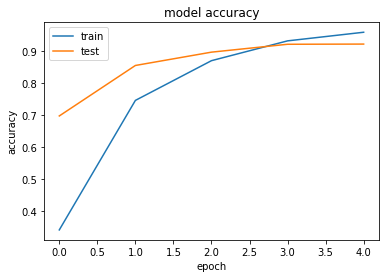

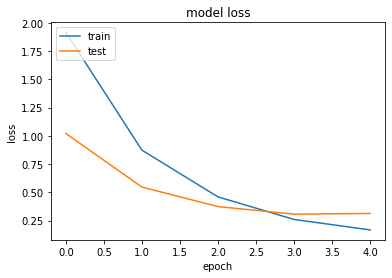

In [ ]:
 import matplotlib.pyplot as plt
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('BERT_S367')

In [ ]:
!pip install patool
import patoolib
patoolib.create_archive("BERT_S367.zip", ("BERT_S367",))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.9 MB/s 
patool: Creating BERT_S367.zip ...
patool: running /usr/bin/7z a -tzip -mx=9 -- BERT_S367.zip BERT_S367
patool: ... BERT_S367.zip created.


In [ ]:
#drive 
from google.colab import drive
drive.mount('/content/drive')  


Mounted at /content/drive


In [ ]:
path = '/content/jsonoutputs.csv'

In [ ]:
datax = tokenizer(
    text=df.description.tolist(),
    add_special_tokens=True,
    max_length=433 ,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [ ]:
input_ids = datax['input_ids']
attention_mask = datax['attention_mask']

In [ ]:
predicted_raw = model.predict({'input_ids':datax['input_ids'],'attention_mask':datax['attention_mask']})
predicted_raw[0]

array([9.3365420e-04, 7.5255934e-04, 8.1710545e-03, 6.0774526e-04,
       5.6645082e-04, 1.1730583e-03, 3.7186416e-03, 9.8278564e-01,
       9.3359537e-05, 1.1977700e-03], dtype=float32)